Using GPU for training

In [1]:
import tensorflow as tf

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print(tf.config.list_physical_devices('GPU'))


Num GPUs Available:  1
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
# conda install -c anaconda openpyxl

Imports

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

Memory work

In [4]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("GPU memory growth enabled")
    except RuntimeError as e:
        print(e)

GPU memory growth enabled


Dataset

In [5]:
df = pd.read_excel("mendeley_student_data.xlsx")
df.head()

,University Admission year,Gender,Age,H.S.C passing year,Program,Current Semester,Do you have meritorious scholarship ?,Do you use University transportation?,How many hour do you study daily?,How many times do you seat for study in a day?,...,What is you interested area?,What is your relationship status?,Are you engaged with any co-curriculum activities?,With whom you are living with?,Do you have any health issues?,What was your previous SGPA?,Do you have any physical disabilities?,What is your current CGPA?,How many Credit did you have completed?,What is your monthly family income?
0,2018,Male,24,2016,BCSE,12,Yes,No,3,2,...,Data Schince,Single,Yes,Bachelor,No,2.68,No,3.15,75,25000
1,2021,Male,22,2020,BCSE,4,Yes,Yes,3,2,...,Event management,Single,Yes,Family,No,2.68,No,3.15,36,100000
2,2020,Female,21,2019,BCSE,5,No,No,3,3,...,Software,Single,No,Bachelor,No,2.68,No,3.15,50,50000
3,2021,Male,20,2020,BCSE,4,Yes,No,1,3,...,Artificial Intelligence,Single,No,Bachelor,Yes,2.68,No,3.15,36,62488
4,2021,Male,22,2019,BCSE,4,Yes,No,3,1,...,Software,Relationship,No,Bachelor,Yes,2.68,No,3.15,36,50000


Target

In [6]:
target_col = 'What is your current CGPA?'
X = df.drop(columns=[target_col])
y = df[target_col].values

Columns fix

In [9]:
# Detect numeric and categorical columns
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object', 'category']).columns.tolist()

# Convert all categorical columns to string (fix mixed-type error)
for col in categorical_features:
    X[col] = X[col].astype(str)


Preprocessing

In [21]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(drop='first'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

X_processed = preprocessor.fit_transform(X)
# Convert to dense if it's sparse
if hasattr(X_processed, "toarray"):
    X_processed = X_processed.toarray()

print("Preprocessing done! Shape of processed X:", X_processed.shape)

Preprocessing done! Shape of processed X: (1194, 176)


Train Test Split

In [22]:
X_train, X_test, y_train, y_test = train_test_split(
    X_processed, y, test_size=0.2, random_state=42
)

# Ensure train/test are dense NumPy arrays
X_train = np.array(X_train, dtype=np.float32)
X_test = np.array(X_test, dtype=np.float32)
y_train = np.array(y_train, dtype=np.float32)
y_test = np.array(y_test, dtype=np.float32)

Bulid ANN model

In [23]:
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='linear')
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 64)                11328     
                                                                 
 dense_7 (Dense)             (None, 32)                2080      
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense_8 (Dense)             (None, 1)                 33        
                                                                 
Total params: 13,441
Trainable params: 13,441
Non-trainable params: 0
_________________________________________________________________


Train model (with gpu)

In [24]:
with tf.device('/GPU:0'):
    history = model.fit(
        X_train, y_train,
        validation_split=0.2,
        epochs=100,
        batch_size=32,
        verbose=1
    )


Epoch 1/100
24/24 [==============================] - 3s 10ms/step - loss: 6.4855 - mae: 2.3735 - val_loss: 1.8480 - val_mae: 1.2091
Epoch 2/100
24/24 [==============================] - 0s 5ms/step - loss: 1.3373 - mae: 0.9108 - val_loss: 0.8522 - val_mae: 0.6011
Epoch 3/100
24/24 [==============================] - 0s 5ms/step - loss: 0.8871 - mae: 0.7227 - val_loss: 0.6678 - val_mae: 0.5598
Epoch 4/100
24/24 [==============================] - 0s 5ms/step - loss: 0.7275 - mae: 0.6628 - val_loss: 0.5628 - val_mae: 0.4649
Epoch 5/100
24/24 [==============================] - 0s 5ms/step - loss: 0.6066 - mae: 0.6194 - val_loss: 0.5301 - val_mae: 0.4482
Epoch 6/100
24/24 [==============================] - 0s 5ms/step - loss: 0.5606 - mae: 0.5965 - val_loss: 0.4671 - val_mae: 0.4028
Epoch 7/100
24/24 [==============================] - 0s 4ms/step - loss: 0.4808 - mae: 0.5517 - val_loss: 0.4148 - val_mae: 0.3683
Epoch 8/100
24/24 [==============================] - 0s 5ms/step - loss: 0.4712 - 

Evaluate

In [25]:
y_pred = model.predict(X_test).flatten()
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Test MSE: {mse:.3f}")
print(f"Test R² Score: {r2:.3f}")


8/8 [==============================] - 0s 1ms/step
Test MSE: 0.120
Test R² Score: 0.767


Plots

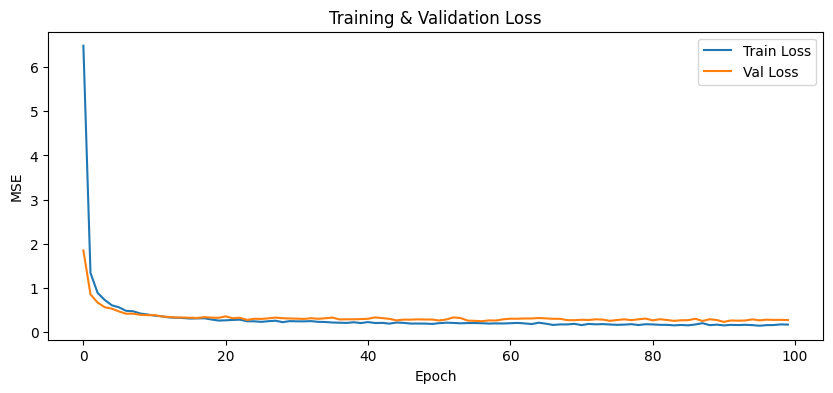

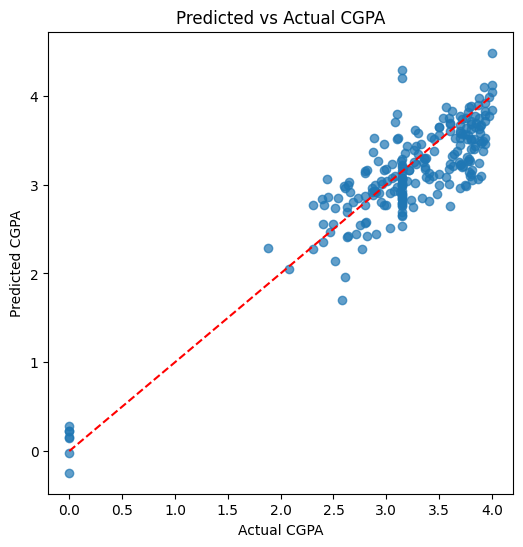

In [26]:
# Loss Curve
plt.figure(figsize=(10,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.title('Training & Validation Loss')
plt.legend()
plt.show()

# Predicted vs Actual
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual CGPA')
plt.ylabel('Predicted CGPA')
plt.title('Predicted vs Actual CGPA')
plt.show()
